# Hybrid autoencoder–MLP pipeline for satellite image classification

## Project Goals

The objective of this project is to design and modify a convolutional autoencoder so that it can be effectively adapted to the task of satellite image classification.
The encoder is used as a feature extractor and its latent representations are employed to train a classifier on top of them.
The goal is to evaluate whether the learned latent space provides meaningful and discriminative features for classifying EuroSAT images.

## Dataset description

EuroSAT dataset (https://www.kaggle.com/datasets/apollo2506/eurosat-dataset) is used for land use and land cover classification in geospatial imagery. The goal is to identify the semantic category represented in each satellite image.

The data consist of small RGB image patches captured by the Sentinel-2 satellite, and each patch corresponds to a specific type of land usage such as agricultural fields, forested areas, or urban environments.

The original EuroSAT dataset includes two folders:
- EuroSAT – containing RGB images
- EuroSATallBands – containing multispectral .tif images (all Sentinel-2 bands)

The dataset used in this project corresponds to the EuroSAT RGB subset, which contains 64×64 pixel RGB images derived from the Sentinel-2 multispectral satellite data. Each image has a Ground Sampling Distance (GSD) of 10 meters, meaning each pixel represents a 10×10 meter area on the ground.

In [1]:
from torchvision.datasets import ImageFolder

data_root = r"C:/Users/Matti/Desktop/Progetto DL/Codice/Dataset/EuroSAT"
full_dataset = ImageFolder(
    root=data_root,
    transform=None  
)

# Class
print("Class names:", full_dataset.classes)

# Class-to-index mapping
print("Class-to-index mapping:", full_dataset.class_to_idx)

Class names: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
Class-to-index mapping: {'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Highway': 3, 'Industrial': 4, 'Pasture': 5, 'PermanentCrop': 6, 'Residential': 7, 'River': 8, 'SeaLake': 9}


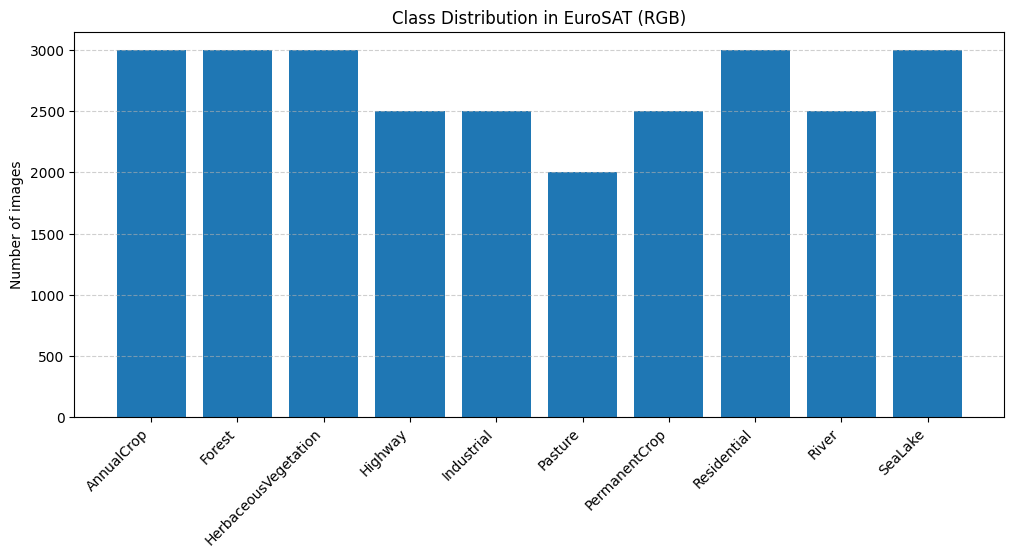

In [2]:
import collections
import matplotlib.pyplot as plt

class_counts = collections.Counter([label for _, label in full_dataset])
labels = [full_dataset.classes[i] for i in class_counts.keys()]
counts = list(class_counts.values())

plt.figure(figsize=(12, 5))
plt.bar(labels, counts)
plt.title("Class Distribution in EuroSAT (RGB)")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Number of images")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

The plot shows the distribution of the ten classes in the EuroSAT RGB dataset.
The dataset is originally well balanced, with each class containing approximately 2,000 to 3,000 images.
Since the total number of images in the dataset is very large, it is necessary to reduce the number of samples to make the project computationally feasible. Therefore, we kept a maximum of 2,000 images per class, matching the size of the smallest class to preserve class balance.

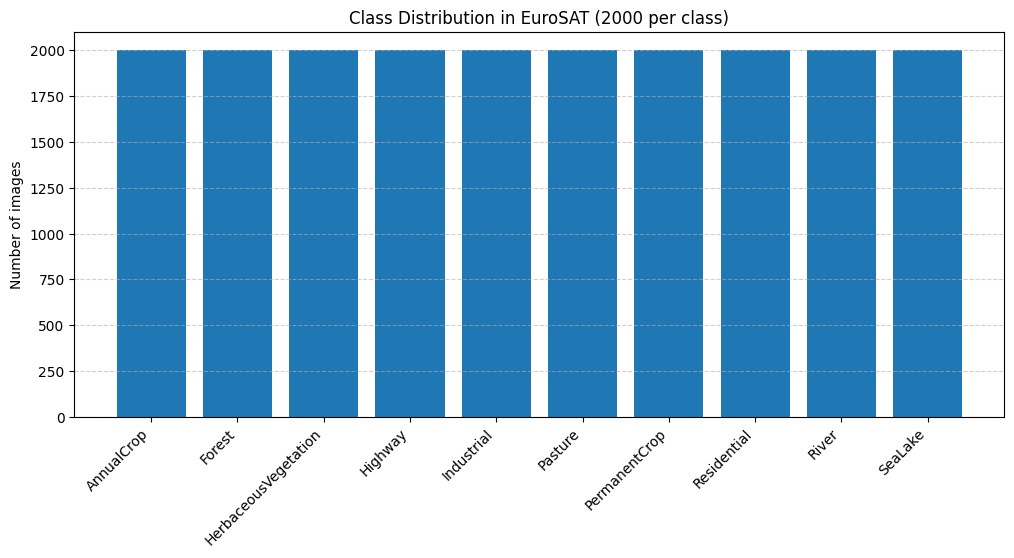

In [3]:
import torch

per_class = 2000

selected_indices = []

for class_idx in range(len(full_dataset.classes)):
    class_all_idx = [i for i, (_, lbl) in enumerate(full_dataset) if lbl == class_idx]
    
    chosen = torch.randperm(len(class_all_idx))[:per_class]
    chosen = [class_all_idx[i] for i in chosen]
    
    selected_indices.extend(chosen)

reduced_dataset = torch.utils.data.Subset(full_dataset, selected_indices)

class_counts = collections.Counter([label for _, label in reduced_dataset])

labels = [full_dataset.classes[i] for i in class_counts.keys()]
counts = list(class_counts.values())

plt.figure(figsize=(12, 5))
plt.bar(labels, counts)
plt.title("Class Distribution in EuroSAT (2000 per class)")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Number of images")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

I display a few sample images to show what the dataset looks like.

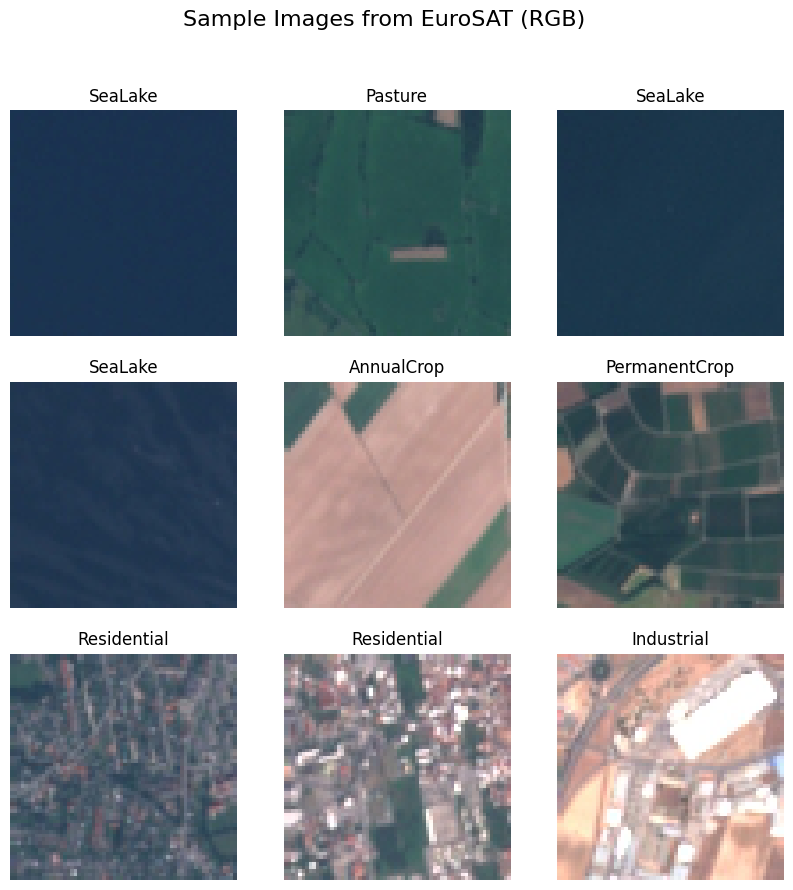

In [4]:
import random

plt.figure(figsize=(10, 10))

for i in range(9):
    idx = random.randint(0, len(full_dataset)-1)
    img, label = full_dataset[idx]

    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(full_dataset.classes[label])
    plt.axis("off")

plt.suptitle("Sample Images from EuroSAT (RGB)", fontsize=16)
plt.show()

## Importing Libraries & Device Configuration

I import the libraries required for the project and set the computation device to GPU if available.

In [5]:
import os
import json
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split
from torchvision import transforms

from tqdm import tqdm

from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report
)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


## Data Preprocessing & DataLoader

To prepare the EuroSAT dataset for training, the reduced dataset is first split into three subsets:
70% for training, 15% for validation, and 15% for testing.
A fixed random seed ensures that the split is fully reproducible.

In [7]:
train_size = int(0.7 * len(reduced_dataset))
val_size   = int(0.15 * len(reduced_dataset))
test_size  = len(reduced_dataset) - train_size - val_size

train_subset, val_subset, test_subset = random_split(
    reduced_dataset,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

Since the original ImageFolder transformation was disabled, a custom wrapper class (TransformDataset) is used to apply preprocessing steps after the dataset split. This guarantees that each subset receives the correct transformation without altering the underlying dataset structure.

In [8]:
class TransformDataset(Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        img, label = self.subset[idx]
        img = self.transform(img)
        return img, label

A custom transformation (AddGaussianNoise) is implemented to inject random noise into the input images. Gaussian Noise consists of adding a random perturbation to the input data according to a normal distribution. This technique is commonly used to train denoising autoencoders and to improve model robustness. By slightly corrupting the input image, the encoder is forced to extract more stable and meaningful features, which enhances generalization and reduces overfitting. Moreover, the added noise acts as a form of regularization, making the latent space smoother and less sensitive to small variations in the data.

In [9]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=0.03):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        noise = torch.randn_like(tensor) * self.std + self.mean
        return tensor + noise

In the implemented preprocessing pipeline, the training set undergoes both data augmentation and noise injection through the following transformations: random horizontal flipping, random cropping conversion to tensors, and the addition of Gaussian noise. Conversely, the validation and test sets use only a minimal preprocessing step (conversion to tensors), ensuring that no augmentation or artificial perturbations affect model evaluation. These transformations are applied through a custom wrapper class (TransformDataset), which assigns the appropriate preprocessing to each subset after the dataset split.

In [10]:
train_transform_ae = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(64, padding=4),
    transforms.ToTensor(),
    AddGaussianNoise(0., 0.03)
])

test_val_transform = transforms.Compose([
    transforms.ToTensor()
])

trainset_ae = TransformDataset(train_subset, train_transform_ae)
valset_ae   = TransformDataset(val_subset,   test_val_transform)
testset_ae  = TransformDataset(test_subset,  test_val_transform)

DataLoaders are created for each subset with a batch size of 64.
Training data is shuffled at every epoch, while validation and test data are loaded in consistent order.

In [11]:
batch_size = 64

train_loader = DataLoader(trainset_ae, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(valset_ae, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(testset_ae, batch_size=batch_size, shuffle=False)

## Autoencoder

Autoencoders are neural architectures designed to learn compact and meaningful representations of data through an unsupervised reconstruction task. They consist of two components: an encoder, which compresses the input into a lower-dimensional latent representation, and a decoder, which reconstructs the original data from this latent code. By minimizing the difference between the input and the reconstruction, the network is encouraged to capture the most essential structures and patterns present in the data. When applied to images, convolutional autoencoders are particularly effective because convolutional layers naturally exploit spatial locality and hierarchical feature extraction.

Since the dataset consists of images, I adopt a Convolutional Autoencoder which is trained to reconstruct the input image and during this process it naturally learns strong spatial and semantic patterns.
The goal of this project is to repurpose these learned representations, not only for reconstruction, but also for image classification.

However, a traditional autoencoder optimizes only a reconstruction loss, which does not encourage the latent space to be discriminative for classification.
For this reason, I extend the model into a supervised autoencoder, adding a classification head and combining two losses: the reconstruction loss and the classification loss.
This forces the encoder to learn features that are useful for both reconstruction and class separation.

### Encoder

The encoder is responsible for transforming the input image into a compact latent representation that captures its most important spatial and semantic features. It progressively reduces the image resolution while increasing the number of channels, allowing the model to extract hierarchical patterns: from low-level textures to high-level structures relevant for land-use classification.

The architecture uses four convolutional blocks with stride 2, which reduce the spatial resolution in stages:

$$
64 \to 32 \to 16 \to 8 \to 4
$$

This depth is chosen because it provides a good balance between compression and information preservation. With fewer layers, the latent representation would remain too large and redundant; with more layers, the spatial information could be overly compressed and lost.

The number of channels increases across the layers $32 \to 64 \to 128 \to 256$ to compensate for the decreasing resolution. As the spatial dimension shrinks, the model is given more feature channels to encode richer and more abstract information. The final feature map ($256 \times 4 \times 4 = 4096$ values) provides enough capacity to capture complex patterns while remaining computationally manageable.

Stride-2 convolutions are preferred over max pooling because they perform learnable downsampling, enabling the network to decide how to compress spatial information in a way that remains invertible by the decoder.
Batch Normalization and ReLU activation promote stable training, faster convergence, and robustness to noise.

A fully connected layer then maps the 4096-dimensional tensor into the latent vector, whose dimensionality (latent_dim) can be tuned independently of the convolutional structure.

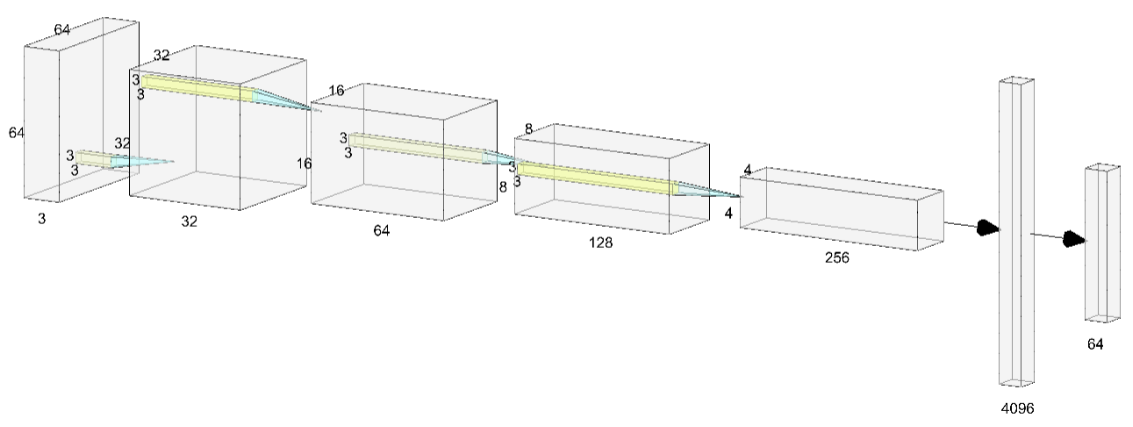

In [12]:
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=2, padding=1),   
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, 64, 3, stride=2, padding=1),  
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 128, 3, stride=2, padding=1), 
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 256, 3, stride=2, padding=1), 
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Flatten(),
            nn.Linear(256*4*4, latent_dim)
        )

    def forward(self, x):
        return self.encoder(x)

#### ReLU Activations
Each convolutional layer is followed by a ReLU activation:

$$
\text{ReLU}(x) = \max(0, x)
$$

ReLU introduces non-linearity and enables the network to learn flexible, non-linear decision boundaries in the latent space. ReLU also avoids vanishing gradients and keeps training efficient.

#### Batch Normalization
After each convolution, a `BatchNorm1d`, which normalizes the activations across the batch:

$$
\hat{x} = \frac{x - \mu}{\sigma}
$$

Batch normalization provides several key benefits:
* stabilizes and accelerates training;
* reduces internal covariate shift;
* smooths the optimization landscape;
* improves generalization.

Batch normalization is especially useful in convolutional encoders, where it helps maintain stable signal propagation throughout deep feature extraction.

### Decoder

The decoder mirrors the encoder, using transposed convolutions to gradually upsample the latent vector back to the original 64 x 64 x 3 image size.

This symmetric design ensures that each upsampling step in the decoder corresponds to a downsampling step in the encoder, helping the network reconstruct spatial structures at the appropriate scale.

The process involves a progressive reduction in channel depth, reflecting the reverse hierarchy of features:

$$
256 \to 128 \to 64 \to 32 \to 3
$$

This transition moves from abstract high-level representations back to pixel-level detail.

Transposed Convolutions are used to perform learnable upsampling. Batch Normalization and ReLU activation are applied after each intermediate layer to stabilize training and avoid vanishing gradients.
The final layer uses a Sigmoid activation function to constrain the output to the range [0, 1], matching the normalized input image format.

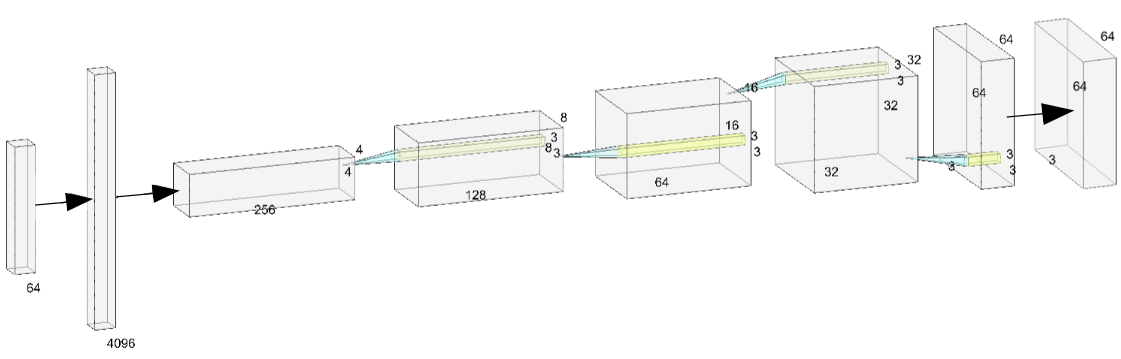

In [13]:
class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()

        self.decoder_input = nn.Linear(latent_dim, 256*4*4)

        self.decoder = nn.Sequential(
            nn.Unflatten(1, (256, 4, 4)),

            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1), 
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),  
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),  
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.ConvTranspose2d(32, 3, 3, stride=2, padding=1, output_padding=1),    
            nn.Sigmoid()   
        )

    def forward(self, z):
        z = self.decoder_input(z)
        z = self.decoder(z)
        return z

#### Transposed Convolution

Transposed convolutions (also called deconvolutions) are used in decoder architectures to increase spatial resolution and reconstruct images from compressed latent representations. While standard convolutions reduce spatial dimensions by aggregating local information, transposed convolutions perform the opposite operation: they expand an input feature map while learning spatial patterns through a trainable kernel.

A transposed convolution can be understood as the transpose of the matrix operation underlying a regular convolution. Instead of sliding the kernel across the input, the kernel is effectively placed around each input element, producing overlapping patches that are summed together to form a larger output. This allows the layer to broadcast information spatially and recover higher-resolution feature maps.

Stride and padding also behave in reverse: stride controls the spacing of the expanded patches (thus enlarging the output) and padding is applied to the output rather than the input, ensuring correct output dimensions.

As in standard convolution, the layer learns a kernel per input channel and a set of kernels per output channel, making transposed convolution a natural counterpart to the encoder’s convolutional layers.

In this project, transposed convolutions are used to progressively upsample the latent vector back to a 64×64×3 RGB image. They provide a principled, learnable alternative to fixed upsampling methods and enable the decoder to reconstruct fine-grained spatial details from the latent space.

### The Latent Space and Classification Head
The latent space is the compressed representation produced by the encoder, where the original image is mapped into a lower dimensional vector that captures its most important structural and semantic features. In this space redundant pixel is removed while the patterns that are most relevant for distinguishing between different land are preserved. Because the latent space is both compact and semantically meaningful, it provides an ideal point for attaching a classifier.

To enable classification directly from this latent representation, a small multilayer perceptron (MLP) is added on top of the latent vector. This MLP consists of two fully connected layers:
$$
\text{latent\_dim} \to 128 \to \text{num\_classes}
$$
The architecture is intentionally lightweight: a shallow MLP is sufficient to model the class boundaries because the encoder already performs most of the feature extraction. Using a small classifier also keeps the model computationally efficient and ensures that most of the learning pressure is placed on the encoder rather than on the classifier itself.
This design encourages the encoder to organize the latent space so that it is not only useful for reconstruction but also discriminative for classification.

In [14]:
class SupervisedAutoencoder(nn.Module):
    def __init__(self, latent_dim, num_classes=10):
        super().__init__()

        self.enc = Encoder(latent_dim)
        self.dec = Decoder(latent_dim)

        self.classifier = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        z = self.enc(x)          
        x_hat = self.dec(z)      
        logits = self.classifier(z)  
        return x_hat, logits, z

## Loss function

The supervised autoencoder is trained by minimizing a composite loss function that jointly accounts for image reconstruction and class prediction:

$$
L = \alpha \cdot L_{\text{recon}} + L_{\text{class}}
$$

This formulation encourages the model to learn a latent representation that is simultaneously expressive enough to reconstruct the input and discriminative enough to support classification.

### Mean Squared Error
The reconstruction term is computed using Mean Squared Error, which measures the average squared difference between the input image $x$ and its reconstruction $\hat{x}$.

$$
L_{\text{recon}} = \| x - \hat{x} \|_2^2
$$

* A low MSE indicates that the decoder is able to faithfully reproduce fine-grained spatial and color information from the latent space.
* A high MSE reflects blurry or inaccurate reconstructions.

Because MSE penalizes larger errors more strongly than smaller ones, it naturally encourages smooth, noise-free reconstructions and stable learning dynamics.

### CrossEntropy
The classification component is computed using CrossEntropy, the standard objective for multi-class prediction. It quantifies the mismatch between the true class label and the predicted class probabilities produced by the classification head.

$$
L_{\text{class}} = - \sum_{c=1}^{C} y_c \, \log(\hat{p}_c)
$$

CrossEntropy encourages the model to assign high confidence to the correct class and penalizes ambiguous or incorrect predictions. This term ensures that the latent space contains class-discriminative information, complementing the reconstruction objective.

The scalar $\alpha$ controls the trade-off between the two objectives:

* Larger values give greater emphasis to reconstruction.
* Smaller values favor learning a stronger classifier.

A detailed discussion of how $\alpha$ influences the training dynamics and the final latent representation is provided in the following section.

### Estimating the relative scale of MSE and CrossEntropy at initialization

Before tuning the reconstruction weight $\alpha$, it is important to understand the natural scale of the two loss components that form the supervised autoencoder objective:

$$
L = \alpha \cdot L_{\text{recon}} + L_{\text{class}}
$$

Since the reconstruction loss (MSE) and the classification loss (CrossEntropy) operate on different numerical scales, choosing an appropriate value for $\alpha$ requires knowing how large these losses are relative to one another at initialization.

If one term is inherently much larger than the other, the model may favor it by default, making the balancing parameter $\alpha$ ineffective unless chosen accordingly.

To estimate this scale difference, the following experiment is performed:

1.  The supervised autoencoder initialize 1000 times each time with freshly sampled random weights (PyTorch initializes weights randomly).
2.  For each initialization, a single batch of training images is passed through the untrained model.
3.  Both the reconstruction loss (MSE) and the classification loss (CrossEntropy) are computed.
4.  The ratio is recorded:

$$
\text{ratio} = \frac{L_{\text{class}}}{L_{\text{recon}}}
$$

This indicates how many times larger the CrossEntropy is compared to the MSE. After repeating the procedure 1000 times, a histogram of the ratios is plotted, showing their  dominating the optimization process.

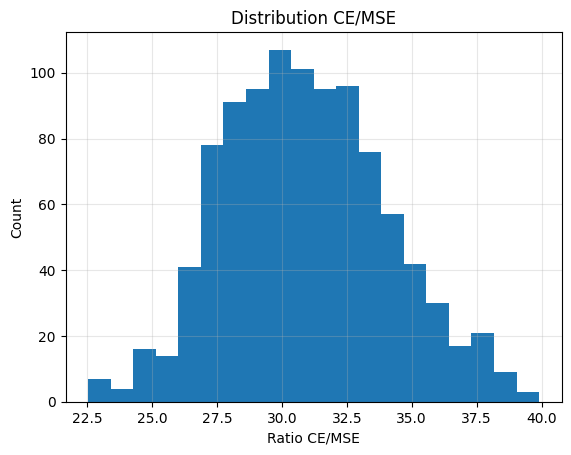

In [15]:
ratios = []

for i in range(1000):
    model = SupervisedAutoencoder(latent_dim=128, num_classes=10).to(device)
    criterion_recon = nn.MSELoss()
    criterion_class = nn.CrossEntropyLoss()

    imgs, labels = next(iter(train_loader))
    imgs = imgs.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        x_hat, logits, _ = model(imgs)
        loss_recon = criterion_recon(x_hat, imgs)
        loss_class = criterion_class(logits, labels)

    ratio = loss_class.item() / loss_recon.item()
    ratios.append(ratio)

plt.hist(ratios, bins=20)
plt.title("Distribution CE/MSE")
plt.xlabel("Ratio CE/MSE")
plt.ylabel("Count")
plt.grid(alpha=0.3)
plt.show()

The distribution is approximately bell-shaped and centered around 30–32, with most values lying in the interval [25, 38]. This result shows that, before training, the classification loss is consistently an order of magnitude larger than the reconstruction loss ($L_{\text{recon}}$).

If alpha=1 were used, the MSE term would contribute very little to the total objective, and the optimization would be dominated by the classification component. To achieve a balanced training process where both reconstruction and classification influence the encoder, alpha should be scaled to approximately match this ratio.

### Hyperparameter Tuning for the Supervised Autoencoder

The behaviour of the supervised autoencoder during training is strongly influenced by two hyperparameters: the weight α assigned to the reconstruction term in the loss function and the learning rate that controls the dynamics of optimization. Although these parameters act on different aspects of the model, together they determine how the latent representation forms and how well the network balances reconstruction and classification.

### Effect of the reconstruction weight α
The parameter α regulates the importance of the reconstruction loss relative to the classification loss.

When α is very large, the training process becomes dominated by the reconstruction objective. In this regime, the decoder learns to reproduce the input images with high fidelity while the classification head receives comparatively weaker gradients. As a consequence, the latent representation tends to encode generic visual information rather than features that are discriminative for the classes, resulting in a high-quality reconstruction but a weak classifier.

When α is very small, the opposite happens. The optimization becomes almost entirely driven by the CrossEntropy loss. The latent space adapts primarily to separate the classes and, as a result, the model becomes effective at classification but significantly worse at reconstructing the inputs. The decoder receives little training signal and the reconstructions degrade, often becoming blurry or structurally inaccurate.

Only when α takes values of the right magnitude do the two objectives complement each other: the latent space retains both geometric structure for reconstruction and discriminative structure for classification, producing an effective compromise between the two tasks.

### Effect on the learning rate
The learning rate affects the model in a different but equally crucial way.

A learning rate that is too high can cause unstable behaviour during optimization. In such cases, the parameter updates become overly aggressive, and the loss may oscillate or diverge rather than decrease smoothly. This instability prevents the autoencoder from forming a coherent latent representation and often results in poor reconstructions and low classification accuracy.

If the learning rate is too small, the training becomes excessively slow and can stagnate. The model may converge toward suboptimal solutions simply because the updates are too small to escape shallow minima or plateaus in the loss landscape.

Only with an appropriately chosen learning rate does the training converge steadily, allowing the model to reduce both losses in a consistent and efficient manner.

## Adam Optimizer

Adam (Adaptive Moment Estimation) is a widely used optimization algorithm in deep learning because it provides stable and efficient training across a broad range of architectures. It combines two key ideas:

* Momentum. Adam maintains an exponentially weighted moving average of past gradients, which smooths the update direction, reduces oscillations, and accelerates convergence compared to standard SGD.

* RMSProp. At the same time, it tracks an exponentially weighted average of squared gradients, allowing each parameter to receive an adaptive learning rate based on the local curvature of the loss surface. This prevents the aggressive learning rate decay.

Adam integrates both mechanisms by estimating the first moment (mean of the gradients) and the second moment (variance). Because these estimates are initially biased toward zero, Adam applies bias-corrected versions of both quantities before computing the final parameter update, ensuring more stable behavior during the early stages of training.

The optimizer is controlled by a small set of hyperparameters:
* α: learning rate (default 0.001)
* β₁: decay rate for the first moment estimate (typically 0.9)
* β₂: decay rate for the second moment estimate (typically 0.999)
* ε: small constant for numerical stability

Adam is effective because it:
* adapts the learning rate individually for each parameter;
* stabilizes training through momentum and variance-based scaling;
* requires minimal hyperparameter tuning compared to SGD-based methods;
* performs reliably on large datasets and complex neural network architectures.

## Autoencoder training with grid search over α and learning rate

To understand how the supervised autoencoder behaves under different training conditions, I performed a grid search over the two hyperparameters. The grid explored spans α values between 20 and 40, guided by the earlier analysis of the CE/MSE scale ratio, and learning rates ranging from $10^{-4}$ to $10^{-1}$. By evaluating every combination, the training process reveals how sensitive the model is to each hyperparameter and which region of the search space leads to stable and well-balanced learning.

The model is trained using the Adam optimizer, which is generally a good default choice for deep neural networks. In practice, this often leads to smoother and faster convergence than plain stochastic gradient descent, especially in architectures that are deep or contain many convolutional layers, such as autoencoders.

For each pair (α,LR) in the grid, the autoencoder starts from scratch with randomly initialized weights. The model is then trained on the training set, while its performance is monitored on the validation set after every epoch. To avoid unnecessary overfitting or wasted computation, early stopping is employed: if the validation loss does not improve for a certain number of consecutive epochs, training is automatically halted. This ensures that each hyperparameter configuration is given enough opportunity to improve, but not so much that optimization drifts into ineffective or unstable regions.

Across all configurations, the validation loss reached during training is recorded. Whenever a model achieves a new lowest validation loss among all runs performed so far, it is marked as the current best model, and its weights are saved. This systematic exploration makes it possible to compare different combinations of reconstruction weight and learning rate in a fair and controlled manner.

At the end of the process, the combination with the lowest validation loss is selected as the optimal configuration. The corresponding model parameters are stored, along with the validation losses for all tested configurations, enabling further analysis of how the hyperparameters influence reconstruction quality, classification performance, and convergence behavior.

In [16]:
#Folder
os.makedirs("models_best", exist_ok=True)

alpha_values = [20, 25, 30, 35, 40]
lr_values = [1e-4, 2e-4, 5e-4, 1e-3, 2e-3, 5e-3, 1e-2, 5e-2, 1e-1]

results_val_losses = {}

# Tracking best model global
global_best_loss = float("inf")
global_best_info = None
global_best_model_state = None

best_train_losses = None
best_val_losses_curve = None

for alpha in alpha_values:
    for learning_rate in lr_values:

        print("\n=====================================")
        print(f"Training AE for α={alpha}, LR={learning_rate}")
        print("=====================================")

        latent_dim = 64
        model = SupervisedAutoencoder(latent_dim=latent_dim, num_classes=10).to(device)

        criterion_recon = nn.MSELoss()
        criterion_class = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        num_epochs = 80
        patience = 15
        counter = 0
        best_val_loss = float("inf")

        train_curve = []
        val_curve = []

        # Train loop
        for epoch in range(num_epochs):

            # Train
            model.train()
            train_loss = 0.0
            n_train = 0

            for imgs, labels in train_loader:
                imgs = imgs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                x_hat, logits, _ = model(imgs)

                loss_recon = criterion_recon(x_hat, imgs)
                loss_class = criterion_class(logits, labels)
                loss = alpha * loss_recon + loss_class

                loss.backward()
                optimizer.step()

                bs = imgs.size(0)
                train_loss += loss.item() * bs
                n_train += bs

            train_loss /= n_train
            train_curve.append(train_loss)

            # Validation
            model.eval()
            val_loss = 0.0
            n_val = 0

            with torch.no_grad():
                for imgs, labels in val_loader:
                    imgs = imgs.to(device)
                    labels = labels.to(device)

                    x_hat, logits, _ = model(imgs)

                    loss_recon = criterion_recon(x_hat, imgs)
                    loss_class = criterion_class(logits, labels)
                    loss = alpha * loss_recon + loss_class

                    bs = imgs.size(0)
                    val_loss += loss.item() * bs
                    n_val += bs

            val_loss /= n_val
            val_curve.append(val_loss)

            print(f"[AE α={alpha} LR={learning_rate}] Epoch {epoch+1} | "
                  f"TrainLoss={train_loss:.4f} | ValLoss={val_loss:.4f}")

            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                counter = 0
            else:
                counter += 1
                if counter >= patience:
                    print("Early stopping triggered.")
                    break
                    
        results_val_losses[(alpha, learning_rate)] = best_val_loss

        # Check global best
        if best_val_loss < global_best_loss:
            global_best_loss = best_val_loss
            global_best_info = (alpha, learning_rate)
            global_best_model_state = model.state_dict()

            best_train_losses = train_curve
            best_val_losses_curve = val_curve

            print("\nNew best AE")
            print(f"   α={alpha}, LR={learning_rate}, ValLoss={best_val_loss:.4f}")

# Save best model
best_alpha, best_lr = global_best_info
best_path = "models_best/AE_GLOBAL_BEST.pt"
torch.save(global_best_model_state, best_path)

print(f"   α={best_alpha}, LR={best_lr}")
print(f"   BEST ValLoss={global_best_loss:.4f}")
print(f"   Saved in: {best_path}\n")

# Save results
results_json = {
    f"alpha={a}, lr={lr}": float(v)
    for (a, lr), v in results_val_losses.items()
}

with open("models_best/validation_losses.json", "w") as f:
    json.dump(results_json, f, indent=4)


Training AE for α=20, LR=0.0001
[AE α=20 LR=0.0001] Epoch 1 | TrainLoss=2.1083 | ValLoss=1.6209
[AE α=20 LR=0.0001] Epoch 2 | TrainLoss=1.2913 | ValLoss=1.5079
[AE α=20 LR=0.0001] Epoch 3 | TrainLoss=1.0424 | ValLoss=1.8195
[AE α=20 LR=0.0001] Epoch 4 | TrainLoss=0.9284 | ValLoss=2.0291
[AE α=20 LR=0.0001] Epoch 5 | TrainLoss=0.8560 | ValLoss=1.8631
[AE α=20 LR=0.0001] Epoch 6 | TrainLoss=0.8198 | ValLoss=2.0593
[AE α=20 LR=0.0001] Epoch 7 | TrainLoss=0.7739 | ValLoss=1.9063
[AE α=20 LR=0.0001] Epoch 8 | TrainLoss=0.7592 | ValLoss=1.8290
[AE α=20 LR=0.0001] Epoch 9 | TrainLoss=0.7194 | ValLoss=2.2182
[AE α=20 LR=0.0001] Epoch 10 | TrainLoss=0.6934 | ValLoss=1.9615
[AE α=20 LR=0.0001] Epoch 11 | TrainLoss=0.6839 | ValLoss=1.9806
[AE α=20 LR=0.0001] Epoch 12 | TrainLoss=0.6590 | ValLoss=2.3349
[AE α=20 LR=0.0001] Epoch 13 | TrainLoss=0.6456 | ValLoss=1.8844
[AE α=20 LR=0.0001] Epoch 14 | TrainLoss=0.6138 | ValLoss=2.0938
[AE α=20 LR=0.0001] Epoch 15 | TrainLoss=0.5975 | ValLoss=2.2643
[

## Training Performance Overview

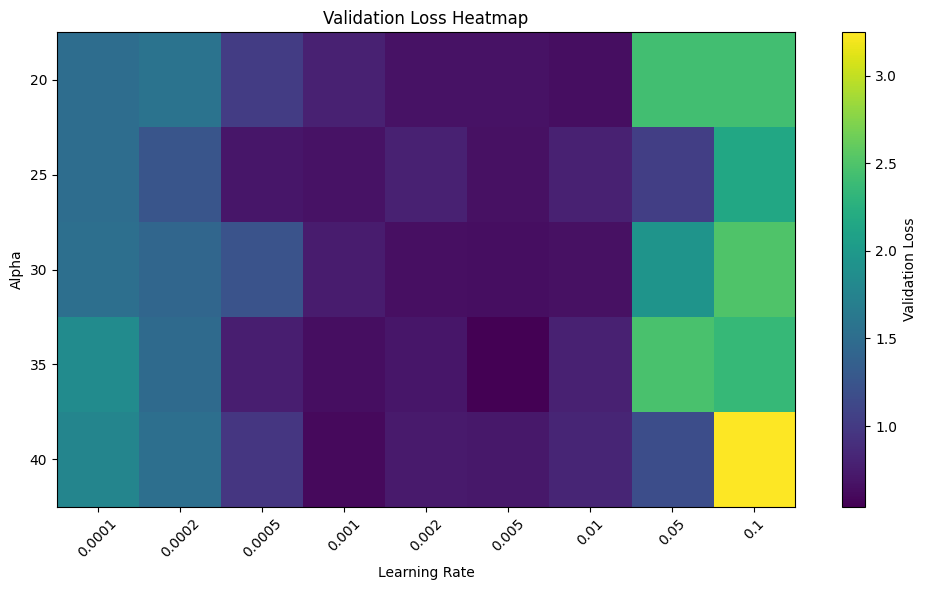

In [18]:
# Load JSON
with open("models_best/validation_losses.json", "r") as f:
    results_json = json.load(f)

heatmap = np.zeros((len(alpha_values), len(lr_values)))

for i, a in enumerate(alpha_values):
    for j, lr in enumerate(lr_values):
        key = f"alpha={a}, lr={lr}"
        heatmap[i, j] = results_json[key]

# Plot heatmap
plt.figure(figsize=(10, 6))
plt.imshow(heatmap, cmap="viridis", aspect="auto")
plt.colorbar(label="Validation Loss")
plt.xticks(range(len(lr_values)), lr_values, rotation=45)
plt.yticks(range(len(alpha_values)), alpha_values)
plt.xlabel("Learning Rate")
plt.ylabel("Alpha")
plt.title("Validation Loss Heatmap")
plt.tight_layout()
plt.show()

The supervised autoencoder performs best with α = 35 and a learning rate of 0.005, achieving a minimum validation loss of 0.5397.

This result shows that all α values in the tested range (20–40) lead to comparable performance, as long as the learning rate lies in the stable region. The heatmap indicates that the learning rate has a much stronger influence on validation loss than the exact choice of α.

The validation-loss heatmap further highlights how the model behaves across different hyperparameter combinations:

* Low LR: Very small learning rates ($10^{-4}, 2 \cdot 10^{-4}$) slow training significantly.
* High LR: Larger learning rates (0.05, 0.1) cause divergence and instability.
* Effective Training: Effective training occurs only within a narrow interval, roughly between $10^{-3}$ and $5 \cdot 10^{-3}$.

Within this stable region, models with higher α values consistently perform better, confirming that giving more weight to the reconstruction term leads to a more well-balanced and effective supervised autoencoder.

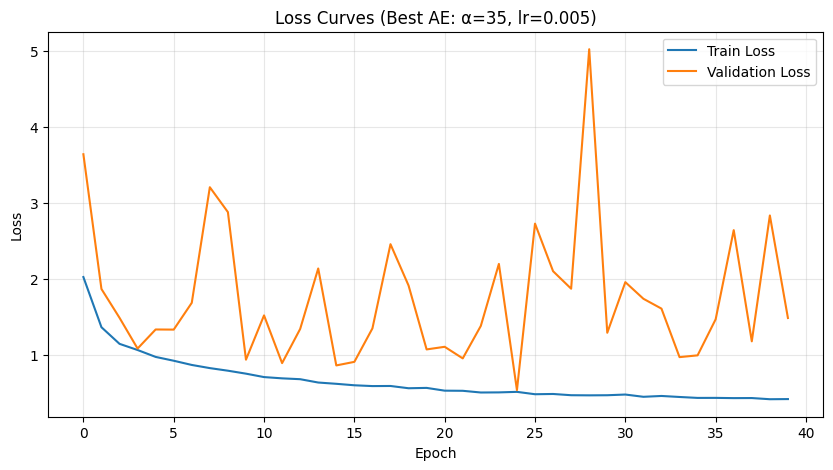

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(best_train_losses, label="Train Loss")
plt.plot(best_val_losses_curve, label="Validation Loss")
plt.title(f"Loss Curves (Best AE: α={best_alpha}, lr={best_lr})")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

The training and validation loss curves for the best model (α = 35, LR = 0.005) reveal a mixed but interpretable behavior. On the one hand, the training loss decreases smoothly and consistently, indicating that the chosen learning rate allows the optimizer to make steady progress without instability. On the other hand, the validation loss exhibits considerable variability across epochs, which is not unexpected in a supervised autoencoder but does suggest that the model’s generalization behavior is less stable than its training dynamics.

This oscillatory pattern reflects the dual nature of the objective: the reconstruction and classification terms respond differently to changes in the latent representation and improvements in one component do not always guarantee improvements in the other. Despite this variability, the validation loss repeatedly returns to relatively low values and eventually achieves the lowest minimum among all tested hyperparameter combinations. However, the fluctuations indicate that the model remains sensitive to initialization and stochasticity during training.

Overall, the combination α = 35 and LR = 0.005 appears to offer the best compromise found in the grid search. It balances reconstruction and classification sufficiently well to outperform other configurations, but the instability in validation loss suggests that the supervised autoencoder does not fully converge to a uniformly smooth solution. The resulting model is functional and reasonably well-balanced, though not perfectly stable, consistent with the inherent difficulty of jointly optimizing reconstruction and classification within a single latent space.

## Extraction of Latent Features

Before training the classifier, it is necessary to convert each image into its corresponding latent representation. The extracted latent vectors form a new dataset on which the classifier is trained. This allows evaluating the discriminative quality of the latent space learned by the autoencoder, independently of the raw input images.

To accomplish this, I define the function `extract_features`, which will be applied after the encoder of the trained autoencoder has been frozen.

The function takes a dataloader and an encoder as input and forwards each batch of images through the encoder to obtain the latent vectors. These vectors are progressively collected into a feature matrix $X$, while the associated labels are stored in a vector $y$. Once all batches have been processed, the function concatenates the results into two complete tensors.

During this phase, the encoder will operate in evaluation mode with gradient computation disabled, ensuring that the extraction is efficient and that its parameters remain unchanged.

The resulting dataset $(X, y)$ will then be used to train the external MLP classifier, which allows evaluating the discriminative quality of the latent space learned for each $(\alpha, \beta)$ configuration.

In [19]:
def extract_features(loader, encoder):
    X_list, y_list = [], []
    encoder.eval()
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device, non_blocking=True)
            z = encoder(imgs)         
            X_list.append(z.cpu())
            y_list.append(labels.cpu())

    X = torch.cat(X_list, dim=0)
    y = torch.cat(y_list, dim=0)
    return X, y

## MLP Classifier

To assess the discriminative quality of the latent representations produced by the autoencoder, I use a Multilayer Perceptron (MLP) as an external classifier. Once the encoder has been frozen and all latent vectors have been extracted, this classifier is trained exclusively on those embeddings. This setup isolates the effect of the latent space itself: the MLP’s performance directly reflects how well each autoencoder configuration organizes the data into class-separable structures, independent of the decoder or reconstruction objective.

The MLP takes as input a latent vector of size input_dim, generated by the encoder, and outputs num_classes logits, which are used to compute the cross-entropy loss during training.

#### 1. Fully Connected Layers (Linear Layers)
The network is intentionally small and composed of three fully connected layers:

$$
\text{Input} \to 128 \text{ units} \to 64 \text{ units} \to \text{num\_classes}
$$

Each linear layer performs an affine transformation and allows the classifier to combine latent features in increasingly abstract ways. Because the autoencoder already compresses the input into a highly informative latent representation, a compact architecture is sufficient; the classifier does not need to be large to achieve meaningful performance.

#### 2. ReLU Activations

#### 3. Batch Normalization

#### 4. Dropout

A dropout layer with probability 0.3 follows the first hidden layer. By randomly deactivating a portion of neurons during training, dropout discourages co-adaptation of features and strengthens generalization. This is particularly valuable in this context, as the classifier operates on pre-extracted features and must avoid overfitting to the latent dataset.

#### 5. Final Linear Layer
The final linear layer maps the 64-dimensional hidden representation to the number of classes, producing a vector of logits:

$$
z = Wh + b
$$

These logits are then passed through the cross-entropy loss (which implicitly applies softmax) to compute class probabilities during training.

Overall, the MLP is deliberately lightweight and regularized: its purpose is not to outperform the autoencoder, but to reveal the discriminative power of the latent space learned under each hyperparameter configuration.

In [20]:
class MLP(nn.Module):
    def __init__(self, input_dim, num_classes=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3), 

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),

            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.net(x)

## Latent-Space MLP Classifier Training and Learning Rate Grid Search

Once the best-performing autoencoder configuration had been identified, the next step was to evaluate how well its latent space supports classification. To do this, the encoder is isolated from the rest of the network, frozen, and used solely as a feature extractor. This ensures that the quality of the latent representations is assessed independently of both the decoder and the reconstruction objective.

The frozen encoder is applied to the training, validation and test sets, producing three matrices of latent vectors alongside their corresponding label vectors. These embeddings replace the original images and serve as input to an external MLP classifier. Because the encoder is fixed, all learning now occurs exclusively within the classifier; this setup makes the learning rate the primary hyperparameter governing optimization dynamics.

To make training tractable and efficient, the extracted latent features are wrapped into new DataLoaders. At this point, the classification task becomes analogous to training on tabular data: each sample is a single latent vector, and the classifier must learn to map this representation into the correct category.

A grid search over multiple learning rates is then conducted to evaluate how sensitive the classifier is to this hyperparameter when operating on the autoencoder’s latent space. Training is performed using the Adam optimizer with weight decay, which provides both adaptive step sizes and mild regularization. Weight decay is particularly useful in this context because the classifier is small and trained on fixed embeddings, making it prone to overfitting unless some form of regularization is applied.

* If the learning rate is too small, the optimizer updates the classifier weights very slowly, preventing the model from fully adapting to the geometry of the latent space. Training may converge, but only toward a weak decision boundary.
* A learning rate that is too large leads to unstable behavior, especially in combination with Batch Normalization layers which amplify sensitivity to overly aggressive updates. At such learning rates, the classifier often becomes unstable and may oscillate or fail to converge.

Between these extremes lies a narrow interval in which the learning rate is appropriately matched to the structure of the latent space. Within this range, the classifier converges efficiently, producing high validation accuracy and demonstrating that the autoencoder has learned a sufficiently discriminative latent representation.

For each learning rate tested, the model checkpoint achieving the highest validation accuracy is stored. After completing the grid search, the best classifier across all configurations is identified and saved, together with its validation and test accuracies. This final model represents the optimal way to leverage the latent space learned by the autoencoder.

In [21]:
os.makedirs("mlp_best", exist_ok=True)

# Load best AE
best_path = "models_best/AE_GLOBAL_BEST.pt"
latent_dim = 64

best_ae = SupervisedAutoencoder(latent_dim=latent_dim, num_classes=10).to(device)
best_ae.load_state_dict(torch.load(best_path, map_location=device))

# Freeze encoder
for p in best_ae.enc.parameters():
    p.requires_grad = False
best_ae.enc.eval()

# Feature extraction
X_train, y_train = extract_features(train_loader, best_ae.enc)
X_val,   y_val   = extract_features(val_loader,   best_ae.enc)
X_test,  y_test  = extract_features(test_loader,  best_ae.enc)

train_dl = DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=True)
val_dl   = DataLoader(TensorDataset(X_val,   y_val),   batch_size=64, shuffle=False)
test_dl  = DataLoader(TensorDataset(X_test,  y_test),  batch_size=64, shuffle=False)

lr_values = [1e-6, 5e-6, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1]
num_epochs = 30

global_best_val = 0
global_best_test = 0
global_best_lr = None
global_best_state = None

for lr in lr_values:
    print(f"\n=====================================")
    print(f"   Training MLP with LR = {lr}")
    print("=====================================")

    clf = MLP(input_dim=latent_dim, num_classes=10).to(device)
    optimizer = torch.optim.Adam(clf.parameters(), lr=lr, weight_decay=1e-4)

    criterion = torch.nn.CrossEntropyLoss()

    train_acc_curve, val_acc_curve = [], []
    train_loss_curve, val_loss_curve = [], []
    best_val_acc = 0

    #Train
    for e in range(num_epochs):
        clf.train()
        correct_train, total_train = 0, 0
        train_loss_sum = 0

        for xb, yb in train_dl:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()

            logits = clf(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()

            train_loss_sum += loss.item() * xb.size(0)
            correct_train += (logits.argmax(1) == yb).sum().item()
            total_train += xb.size(0)

        train_acc = correct_train / total_train
        train_loss = train_loss_sum / total_train

        # Validation
        clf.eval()
        correct_val, total_val = 0, 0
        val_loss_sum = 0

        with torch.no_grad():
            for xb, yb in val_dl:
                xb, yb = xb.to(device), yb.to(device)
                logits = clf(xb)
                loss = criterion(logits, yb)

                val_loss_sum += loss.item() * xb.size(0)
                correct_val += (logits.argmax(1) == yb).sum().item()
                total_val += xb.size(0)

        val_acc = correct_val / total_val
        val_loss = val_loss_sum / total_val

        train_acc_curve.append(train_acc)
        val_acc_curve.append(val_acc)
        train_loss_curve.append(train_loss)
        val_loss_curve.append(val_loss)

        print(f"Epoch {e+1}/{num_epochs} | TrainAcc={train_acc:.3f} ValAcc={val_acc:.3f}")

        # Best val
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state_lr = clf.state_dict().copy()

    # Test
    clf.load_state_dict(best_state_lr)
    clf.eval()

    correct_test, total_test = 0, 0
    with torch.no_grad():
        for xb, yb in test_dl:
            xb, yb = xb.to(device), yb.to(device)
            preds = clf(xb).argmax(1)
            correct_test += (preds == yb).sum().item()
            total_test += xb.size(0)

    test_acc = correct_test / total_test

    # Save plots
    if best_val_acc > global_best_val:
        global_best_val = best_val_acc
        global_best_test = test_acc
        global_best_lr = lr
        global_best_state = best_state_lr.copy()

        plt.figure(figsize=(8,5))
        plt.plot(train_acc_curve, label="Train")
        plt.plot(val_acc_curve, label="Validation")
        plt.title(f"Accuracy Curve – Best LR = {lr}")
        plt.legend()
        plt.grid()
        plt.savefig("mlp_best/best_lr_accuracy_curve.png")
        plt.close()

        plt.figure(figsize=(8,5))
        plt.plot(train_loss_curve, label="Train")
        plt.plot(val_loss_curve, label="Validation")
        plt.title(f"Loss Curve – Best LR = {lr}")
        plt.legend()
        plt.grid()
        plt.savefig("mlp_best/best_lr_loss_curve.png")
        plt.close()

# Save best MLP
torch.save(global_best_state, "mlp_best/MLP_GLOBAL_BEST.pt")

print("\n--------------------------------------")
print("Best MLP")
print("--------------------------------------")
print(f"Best LR             = {global_best_lr}")
print(f"Best Validation Acc = {global_best_val:.4f}")
print(f"Test Acc (finale)   = {global_best_test:.4f}")

C:\Users\Matti\AppData\Local\Temp\ipykernel_7444\1534089791.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_ae.load_state_dict(torch.load(best_path, map_location=de


   Training MLP with LR = 1e-06
Epoch 1/30 | TrainAcc=0.115 ValAcc=0.178
Epoch 2/30 | TrainAcc=0.125 ValAcc=0.190
Epoch 3/30 | TrainAcc=0.130 ValAcc=0.197
Epoch 4/30 | TrainAcc=0.141 ValAcc=0.208
Epoch 5/30 | TrainAcc=0.146 ValAcc=0.213
Epoch 6/30 | TrainAcc=0.164 ValAcc=0.225
Epoch 7/30 | TrainAcc=0.166 ValAcc=0.232
Epoch 8/30 | TrainAcc=0.177 ValAcc=0.247
Epoch 9/30 | TrainAcc=0.194 ValAcc=0.253
Epoch 10/30 | TrainAcc=0.198 ValAcc=0.257
Epoch 11/30 | TrainAcc=0.215 ValAcc=0.269
Epoch 12/30 | TrainAcc=0.221 ValAcc=0.284
Epoch 13/30 | TrainAcc=0.237 ValAcc=0.301
Epoch 14/30 | TrainAcc=0.249 ValAcc=0.313
Epoch 15/30 | TrainAcc=0.262 ValAcc=0.325
Epoch 16/30 | TrainAcc=0.280 ValAcc=0.335
Epoch 17/30 | TrainAcc=0.292 ValAcc=0.358
Epoch 18/30 | TrainAcc=0.307 ValAcc=0.382
Epoch 19/30 | TrainAcc=0.320 ValAcc=0.396
Epoch 20/30 | TrainAcc=0.334 ValAcc=0.432
Epoch 21/30 | TrainAcc=0.358 ValAcc=0.456
Epoch 22/30 | TrainAcc=0.366 ValAcc=0.471
Epoch 23/30 | TrainAcc=0.379 ValAcc=0.486
Epoch 24/3

## Results

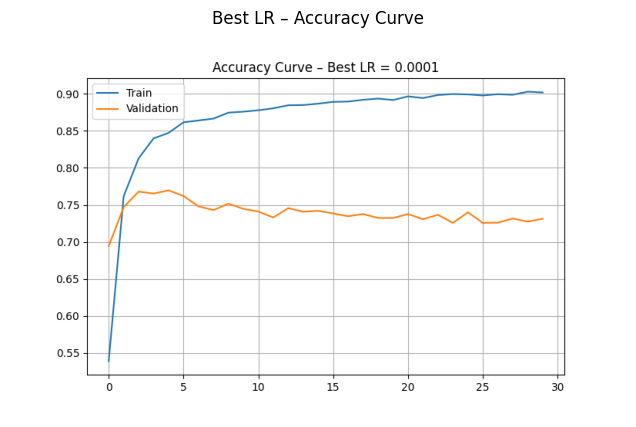

In [23]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread("mlp_best/best_lr_accuracy_curve.png")
plt.figure(figsize=(8, 5))
plt.imshow(img)
plt.axis('off')
plt.title("Best LR – Accuracy Curve")
plt.show()

The accuracy curve for the best learning rate (0.0001) exhibits a characteristic but somewhat irregular training dynamic. The training accuracy increases smoothly throughout the entire training process and eventually approaches 90%, which indicates that the MLP classifier is able to fit the latent representations extracted from the autoencoder without difficulty.

The validation accuracy increases rapidly during the first few epochs, reaching a peak of around 0.76. This indicates that the classifier is able to immediately exploit the portions of the latent space that are already well-structured and separable. After this initial phase, however, the validation accuracy gradually declines and stabilizes at a lower plateau (≈0.72–0.75). This behaviour suggests that the classifier quickly extracts all the generalizable structure available in the latent vectors, and further training only leads to overfitting on the training embeddings without improving true generalization.

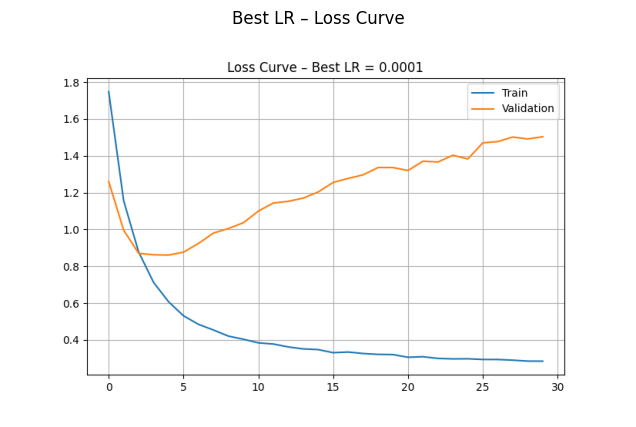

In [24]:
img = mpimg.imread("mlp_best/best_lr_loss_curve.png")
plt.figure(figsize=(8, 5))
plt.imshow(img)
plt.axis('off')
plt.title("Best LR – Loss Curve")
plt.show()

The loss curve highlights even more clearly the overfitting behaviour already suggested by the accuracy curve. The training loss decreases smoothly and monotonically over the entire training process, approaching values below 0.3. This indicates that the MLP classifier is able to fit the latent representations extremely well: optimization is stable and the learning rate of 0.0001 is sufficiently small to avoid oscillations or divergence.

In contrast, the validation loss displays a markedly different trend. It initially decreases during the first few epochs, reflecting the model’s early ability to exploit the structure present in the latent space, but shortly afterwards it begins to rise steadily. From epoch 5 onward, the validation loss increases almost monotonically, eventually reaching values above 1.5. The classifier continues to adapt to the latent vectors in the training set, but does so in a way that harms generalization to unseen data.

The shape of this curve is especially informative. Unlike cases where validation loss fluctuates due to noise, here the increase is smooth and consistent, indicating that the classifier is systematically departing from the regions of latent space that generalize well. This behaviour suggests that the latent representations lack strong class-separating margins. Because the encoder was not explicitly trained to produce discriminative embeddings, the classifier can lower its loss on the training set but cannot find similarly effective boundaries in the validation set.

C:\Users\Matti\AppData\Local\Temp\ipykernel_7444\1250368632.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  clf.load_state_dict(torch.load("mlp_best/MLP_GLOBAL_BEST.pt")

<Figure size 800x800 with 0 Axes>

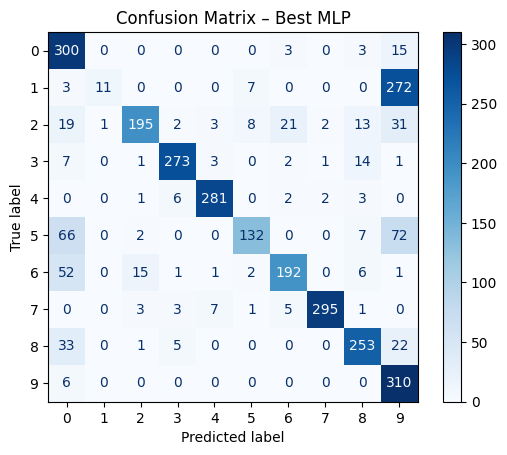

In [25]:
#Load best model
clf = MLP(input_dim=latent_dim, num_classes=10).to(device)
clf.load_state_dict(torch.load("mlp_best/MLP_GLOBAL_BEST.pt"))
clf.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for xb, yb in test_dl:
        xb = xb.to(device)
        preds = clf(xb).argmax(1).cpu()
        all_preds.append(preds)
        all_labels.append(yb)

all_preds = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8,8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix – Best MLP")
plt.show()


In [26]:
print(classification_report(all_labels, all_preds, digits=4))

              precision    recall  f1-score   support

           0     0.6173    0.9346    0.7435       321
           1     0.9167    0.0375    0.0721       293
           2     0.8945    0.6610    0.7602       295
           3     0.9414    0.9040    0.9223       302
           4     0.9525    0.9525    0.9525       295
           5     0.8800    0.4731    0.6154       279
           6     0.8533    0.7111    0.7758       270
           7     0.9833    0.9365    0.9593       315
           8     0.8433    0.8057    0.8241       314
           9     0.4282    0.9810    0.5962       316

    accuracy                         0.7473      3000
   macro avg     0.8311    0.7397    0.7221      3000
weighted avg     0.8272    0.7473    0.7247      3000



The confusion matrix shows that, despite an overall test accuracy of 74.73%, the classifier’s performance varies substantially across classes, reflecting limitations in how the autoencoder organizes the latent space.

Several categories form clean, compact clusters in the latent space and are classified reliably. Industrial (4), Residential (7), Highway (3), SeaLake (9) all achieve high recall (≥0.90). These classes have strong visual signatures (regular structures, built environments or uniform water textures) which the encoder can represent clearly.

Vegetation related categories show noticeable confusion. HerbaceousVegetation (2), Pasture (5), and PermanentCrop (6) often overlap. Their visual similarities (texture, color, vegetation density) are compressed into nearby latent regions, making them difficult to distinguish.

Two classes exhibit severe imbalance:
* Forest (1) has very low recall (0.04) and is mostly misclassified as SeaLake (9), indicating a collapse of its embeddings into the wrong latent region.
* SeaLake (9) obtains very high recall (0.98) but low precision (0.43), acting as an attractor for samples from other categories.

AnnualCrop is not problematic but shows asymmetry. It has a high recall (0.93) but lower precision (0.62). Many vegetation-related samples drift into this cluster, again reflecting overlap in how the encoder represents plant-dominated landscapes.

## Conclusion

This project examined whether a supervised convolutional autoencoder can learn a latent space that is not only compact enough for image reconstruction but also sufficiently structured to support downstream land-use classification. The model was extensively tuned through a grid search over both the reconstruction weight α and the learning rate. The most stable and performant configuration (α = 35, LR = 0.005) produced a well-behaved training loss and consistent convergence during reconstruction.

However, the validation loss displayed significant variability, indicating that the autoencoder struggled to maintain a coherent balance between reconstruction and classification across different minibatches. This instability already suggested that the latent space might not be uniformly structured.

Once the encoder was frozen and used purely as a feature extractor, these limitations became clearer. Although the external MLP classifier could fit the training embeddings easily, reaching above 90% accuracy, the validation and test performance remained significantly lower (76.97% and 74.73%, respectively) and the loss curves showed a widening gap between training and validation behavior. This mismatch indicates that the latent representations, rather than the classifier itself, impose a strong bottleneck on generalization.

The confusion matrix confirms that the latent space is only partially discriminative. Visually distinctive classes such as Industrial, Residential, Highway, and SeaLake form well-separated clusters, consistently achieving high recall. In contrast, vegetation-related categories (Herbaceous Vegetation, Pasture, Permanent Crop) frequently overlap and the Forest class collapses almost entirely into the SeaLake region. These systematic errors reveal that the autoencoder compresses semantically different classes into overlapping or ambiguous latent regions, limiting the classifier’s ability to distinguish them even with sufficient capacity.

Performance is constrained by how the encoder organizes the data, rather than by the classifier’s capacity. The latent space retains enough structure to separate visually distinctive categories but fails to preserve finer distinctions, revealing fundamental representational limits in the autoencoder architecture for this task.

## Future work and possible improvements

Although the supervised autoencoder was able to learn meaningful latent representations, several targeted adjustments could help mitigate the limitations observed in the experiments.

#### Refine the loss balance and training stability.
  
The experiments revealed that the interaction between the reconstruction loss (MSE) and the classification loss (CrossEntropy) can lead to oscillations in validation performance. Further exploration of the reconstruction weight α, potentially combined with techniques such as learning-rate scheduling or gradient clipping, could help stabilize training and yield a more consistent latent space. Improving stability may also mitigate some of the extreme class collapses observed in the confusion matrix.

#### Strengthen the MLP classifier.
Since the encoder is frozen during classification, the burden of separating classes falls entirely on the MLP. Adding an extra hidden layer, increasing the size of existing layers or tuning dropout could enable the classifier to better exploit the structure present in the embeddings.

#### Apply stronger data augmentation.
Rotations, flips, color jitter and small geometric transformations during autoencoder training could help the encoder generalize better and produce more robust latent representations. This is particularly relevant for classes with high intra-class variability.

#### Emphasize hard vegetation classes.
Vegetation related categories, particularly Forest, systematically exhibit high misclassification rates. Introducing class-dependent weighting in the classification loss (e.g., weights proportional to validation error) or applying targeted class-specific data augmentation could bias the encoder toward learning more discriminative latent features for these challenging classes.

#### Increase the capacity of the encoder–decoder architecture.
A more substantial modification would be to increase the overall capacity of the autoencoder by adding additional convolutional blocks, widening existing layers or introducing skip connections. The current encoder compresses the input very aggressively in only four steps, which may cause visually similar classes, especially vegetation types, to collapse into overlapping regions of the latent space. A deeper or wider encoder could extract richer high-level features before compression, while a slightly more expressive decoder would help maintain reconstruction stability. Although more computationally demanding, increasing model capacity would directly address the structural bottlenecks observed in the latent representations.

#### Stabilize classifier training on latent embeddings.
The classification curves showed that the MLP can overfit the latent vectors even when regularized, leading to oscillatory or uneven validation accuracy. Exploring additional regularization strategies such as stronger weight decay, alternative dropout rates or adjusting the batch size could help smooth the optimization process and improve generalization. Since the encoder is frozen, even small improvements in classifier stability may lead to more reliable performance without altering the autoencoder itself.